In [1]:
import matplotlib.pyplot as plt

import iris.plot as iplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from palettable import colorbrewer

cmap = colorbrewer.get_map('RdYlGn', 'diverging', 11, reverse=True).mpl_colormap


def plot_mdt(mdt, projection=ccrs.PlateCarree(), figsize=(12, 10)):
    """Plota 'Mean Dynamic Topography' no mapa global."""
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.LAND, facecolor='0.75')
    cs = iplt.pcolormesh(mdt, cmap=cmap)
    ax.coastlines()
    if isinstance(projection, ccrs.PlateCarree) or isinstance(projection, ccrs.Mercator):
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.5,
                          color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    cbar = fig.colorbar(cs, extend='both', orientation='vertical', shrink=0.6)
    cbar.ax.set_title('[m]')
    return fig, ax

In [2]:
import iris


cube = iris.load_cube('./data/mdt_cnes_cls2009_global_v1.1.nc',
                      iris.Constraint('Mean Dynamic Topography'))

print(cube)

Mean Dynamic Topography / (m)       (longitude: 1440; latitude: 720)
     Dimension coordinates:
          longitude                           x               -
          latitude                            -               x
     Attributes:
          CreatedBy: rio@px-124.cls.fr
          CreatedOn: 11-MAR-2010 16:50:55:000000
          FileType: GRID_DOTS
          OriginalName: MDT_CNES-CLS09_v1.1.nc
          title: MDT CNES-CLS09 V1.1


In [3]:
import numpy as np
import numpy.ma as ma


# Mask bad data out.
data = cube.data.filled(fill_value=np.NaN).copy()
data[data == 9999.0] = np.NaN
data = np.ma.masked_invalid(data)
cube.data = data

In [4]:
cube.coord(axis='X').guess_bounds()
cube.coord(axis='Y').guess_bounds()

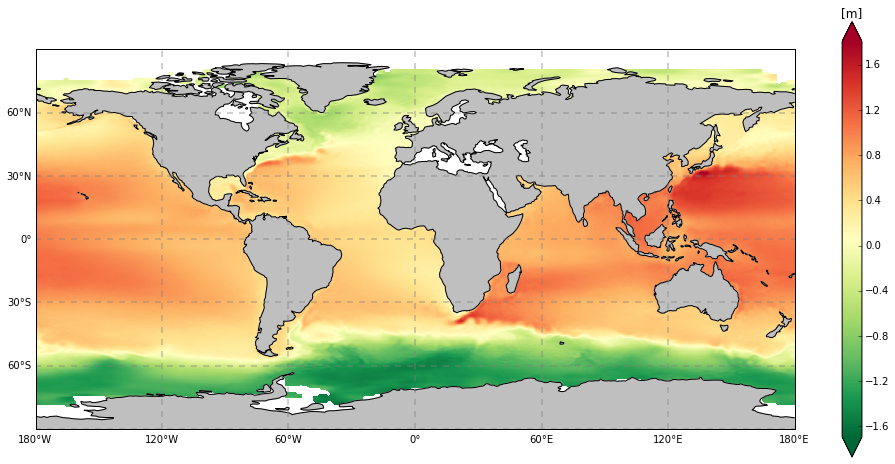

In [5]:
import os


%matplotlib inline

fmt = 'png'
figsize = (17, 13)
kfig = dict(format=fmt, transparent=True, dpi=75)

fig, ax = plot_mdt(cube, projection=ccrs.PlateCarree(), figsize=figsize)

fname = 'MDT_PlateCarree.%s' % fmt
fig.savefig(fname, **kfig)
_ = os.system('convert -trim %s %s' % (fname, fname))

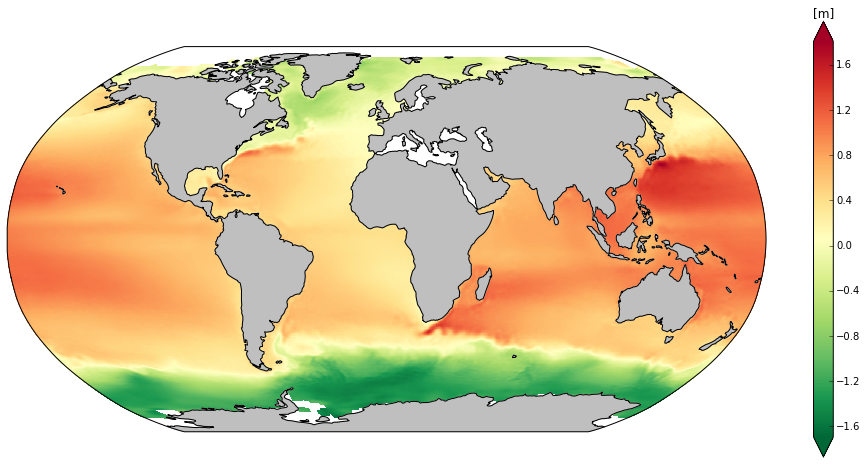

In [6]:
fig, ax = plot_mdt(cube, projection=ccrs.Robinson(), figsize=figsize)


fname = 'MDT_Robinson.%s' % fmt
fig.savefig(fname, **kfig)
_ = os.system('convert -trim %s %s' % (fname, fname))